In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from skimage import measure
from os import listdir,path
import os
from skimage import io
import torch
from dataloaders import Dataset_color
from Ctorch import *
from WienerCNN import WienerFunction
from torch import nn as nn
torch.cuda.set_device(2)
from supplementary import *
from functions import *

# Dataset

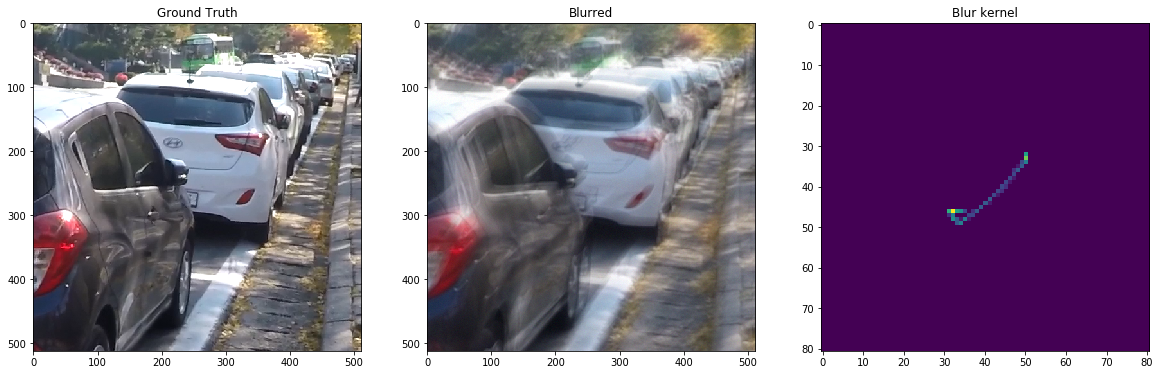

In [152]:
testset = Dataset_color('dataset/',img_size=(512,512),train=False);
(x,y,k,l) = testset[100];
fig,ax=plt.subplots(1,3,figsize=(20,60));
ax[0].imshow(x.permute(1,2,0));
ax[0].set_title('Ground Truth')
ax[1].imshow(y.permute(1,2,0));
ax[1].set_title('Blurred')
ax[2].imshow(k[0,:,:]);
ax[2].set_title('Blur kernel');

## Checking gradientss of trainble Wiener Filter

#### With PyTorch gradchecker

In [4]:
from torch.autograd import Variable, gradcheck

y = Variable(torch.rand(2,1,32,32).double(), requires_grad=True).cuda();
k = torch.rand(2,1,5,5).double().cuda();
k = k/(torch.sum(torch.sum(k, dim=3), dim=2)[:,:,None,None]).cuda();
k = Variable(k.double(), requires_grad=False)
lam = Variable(torch.rand(1).double(), requires_grad=True).cuda().squeeze(0);
weights = torch.rand(3,1,3,3).cuda();
weights = weights/(torch.sum(torch.sum(weights, dim=3), dim=2)[:,:,None,None]);
weights = Variable(weights.double(), requires_grad=True)

test = gradcheck(WienerFunction.apply, (y, k, lam, weights), eps=1e-6, atol=1e-4);
print(test)

True


#### With handmade gradchecker

In [3]:
MyGradCheck_Wiener(WienerFunction, (y, k, lam, weights), eps=1e-8, tol=1e-6)

Mean input grad difference:
tensor(-0.0000, device='cuda:2', dtype=torch.float64)


Lambda grad difference:
tensor(1.7985e-07, device='cuda:2', dtype=torch.float64)


Mean weights grad difference:
tensor(-0.0000, device='cuda:2', dtype=torch.float64)


True

## Checking gradients of trainble Fourier Deconvolution Filter

#### With PyTorch gradchecker

In [141]:
from torch.autograd import Variable, gradcheck

y = Variable(torch.rand(2,1,32,32).double(), requires_grad=False).cuda();
k = torch.rand(2,1,5,5).double().cuda();
k = k/(torch.sum(torch.sum(k, dim=3), dim=2)[:,:,None,None]).cuda();
k = Variable(k.double(), requires_grad=False)
w = Variable(torch.rand(2,1).double(), requires_grad=True).cuda().squeeze(0);
phi = Variable(torch.rand(2,1,32,32).double(), requires_grad=True).cuda();
weights = torch.rand(3,1,3,3).cuda();
weights = weights/(torch.sum(torch.sum(weights, dim=3), dim=2)[:,:,None,None]);
weights = Variable(weights.double(), requires_grad=True)

test = gradcheck(FourierDeconvolutionFunction_init.apply, (y, k, w, phi, weights), eps=1e-8, atol=1e-4);
print(test)

/home/koshelev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'


True


#### With handmade gradchecker

In [142]:
MyGradCheck_Fourier_stage1(FourierDeconvolutionFunction_init,(y, k, w, phi, weights), eps=1e-8, tol=1e-5)

Mean w grad difference:
tensor(-0.0000, device='cuda:2', dtype=torch.float64, grad_fn=<MeanBackward1>)


Mean phi grad difference:
tensor(-0.0000, device='cuda:2', dtype=torch.float64, grad_fn=<MeanBackward1>)


Mean weights grad difference:
tensor(-0.0000, device='cuda:2', dtype=torch.float64, grad_fn=<MeanBackward1>)


/home/koshelev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'


True

In [3]:
3.920/(2**(1/2))

2.7718585822512662